# Análise Preditiva de Acesso a Recursos (Amazon) - Equipe 2

## CRISP-DM: Data Preparation & Modelling

### Objetivo
Desenvolver e avaliar modelos de machine learning para predição de acesso a recursos da Amazon, incluindo preparação e transformação dos dados, tratamento de desbalanceamento de classes, otimização de hiperparâmetros e comparação de diferentes algoritmos de classificação para determinar se um funcionário deve ter acesso a determinados recursos.

### Informações do Dataset
- **Fonte**: Amazon Employee Access Challenge
- **Problema**: Classificação binária (0 = Acesso Negado, 1 = Acesso Permitido)
- **Dados de Treinamento**: 32.769 registros

## 0. Configurações Iniciais

### 0.1 Importação de Bibliotecas e Configurações

In [11]:
# # Instalando Dependências
# # Descomente a célula somente se estiver rodando pela primeira vez 
# %pip install -r requirements.txt

In [19]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, loguniform
import joblib

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import NeighbourhoodCleaningRule
from category_encoders import TargetEncoder

# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklvq import GMLVQ


import warnings
warnings.filterwarnings('ignore')

# Configurações para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Garante que a pasta 'modelos' existe
import os
os.makedirs('modelos', exist_ok=True)

### 0.2 Definição de LVQ

In [4]:
class LVQ(GMLVQ):
    def predict(self, X):
        decision_values = self.decision_function(X)
        
        if self.classes_.size == 2:
            return self.classes_[(decision_values > 0).astype(np.int64)]  # Changed from np.int to np.int64
        
        return self.classes_[decision_values.argmax(axis=1)]

## 1. Carregamento dos Dados

Nesta seção, realizamos o carregamento dos dados.

In [3]:
# Carregamento dos dados de treinamento
train_df = pd.read_csv('data/train.csv')

# Separar features e target
X = train_df.drop(columns=['ACTION'])
y = train_df['ACTION']

# (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

## 2. Pré-processamento
Como a fase de Análise de Dados já foi feita anteriormente no arquivo `projeto_analise.ipynb`, vamos para o pré-processamento.

In [5]:
# Lista de colunas que são categorias, mas estão com tipo numérico
categorical_int_cols = [
    'MGR_ID',
    'ROLE_ROLLUP_2',
    'ROLE_DEPTNAME',
    'ROLE_TITLE',
    'ROLE_FAMILY_DESC',
    'ROLE_CODE',
    'RESOURCE'
]
for col in categorical_int_cols:
    X_train[col] = X_train[col].astype(str) # Ou .astype('object')
    X_test[col] = X_test[col].astype(str) # o mesmo no teste!
    
print("Novos tipos de dados em X_train:")
print(X_train[categorical_int_cols].info())

Novos tipos de dados em X_train:
<class 'pandas.core.frame.DataFrame'>
Index: 26215 entries, 10137 to 31226
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MGR_ID            26215 non-null  object
 1   ROLE_ROLLUP_2     26215 non-null  object
 2   ROLE_DEPTNAME     26215 non-null  object
 3   ROLE_TITLE        26215 non-null  object
 4   ROLE_FAMILY_DESC  26215 non-null  object
 5   ROLE_CODE         26215 non-null  object
 6   RESOURCE          26215 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB
None


### 2.1 Divisão das colunas em alta e baixa cardinalidade e remoção de colunas.

In [6]:
# Remover as colunas indesejadas
cols_to_remove = ['ROLE_ROLLUP_1', 'ROLE_FAMILY']
X_train_clean = X_train.drop(columns=cols_to_remove, errors='ignore')
X_test_clean = X_test.drop(columns=cols_to_remove, errors='ignore')

In [7]:
low_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() < 450]
high_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() >= 450]

low_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() < 450]
high_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() >= 450]

print("Colunas de baixa e alta cardinalidade em X_train_clean:")
print("Baixa cardinalidade:", low_card_features)
print("Alta cardinalidade:", high_card_features)

print("\nColunas de baixa e alta cardinalidade em X_train:")
print("Baixa cardinalidade:", low_card_features_2)
print("Alta cardinalidade:", high_card_features_2)

Colunas de baixa e alta cardinalidade em X_train_clean:
Baixa cardinalidade: ['ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_CODE']
Alta cardinalidade: ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC']

Colunas de baixa e alta cardinalidade em X_train:
Baixa cardinalidade: ['ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY', 'ROLE_CODE']
Alta cardinalidade: ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC']


### 2.2 Comparação de Estratégias de Pré-processamento

Neste experimento, avaliamos o impacto da remoção de colunas no pré-processamento dos dados. Foram testados dois cenários:

- **Com remoção de colunas:**  
    As colunas `ROLE_ROLLUP_1` e `ROLE_FAMILY` foram removidas antes do pré-processamento.

- **Sem remoção de colunas:**  
    Todas as colunas originais foram mantidas no pré-processamento.

O pré-processador utilizado para ambos os cenários foi:

- **Pré-processador para os modelos:**  
    `OneHotEncoder` para variáveis de baixa cardinalidade (`low_cardinality_features`) e `TargetEncoder` para variáveis de alta cardinalidade (`high_cardinality_features`).

A comparação dos resultados permite avaliar se a exclusão dessas colunas influencia o desempenho dos modelos de classificação.

In [8]:

# Pré-processador para X_train_clean
preprocessor_clean = ColumnTransformer(transformers=[
    ('low_card', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary', min_frequency=0.01), low_card_features),
    ('high_card', TargetEncoder(smoothing=1.0, min_samples_leaf=20), high_card_features)
], remainder='passthrough')

# Pré-processador para X_train (todas as colunas)
preprocessor_full = ColumnTransformer(transformers=[
    ('low_card', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary', min_frequency=0.01), low_card_features_2),
    ('high_card', TargetEncoder(smoothing=1.0, min_samples_leaf=20), high_card_features_2)
], remainder='passthrough')

In [9]:
def create_pipeline(classifier, use_full=False):
    """
    Cria um pipeline de ML com pré-processamento, padronização condicional,
    reamostragem e um classificador.
    
    A padronização (StandardScaler) é adicionada APENAS para modelos
    sensíveis à escala das features.
    
    Parâmetros:
    - classifier: o estimador/classificador a ser usado.
    - use_full: se True, usa preprocessor_full; senão, usa preprocessor_clean.
    """
    preproc = preprocessor_full if use_full else preprocessor_clean
    
    ncr_resampler = NeighbourhoodCleaningRule(
        sampling_strategy='majority',
        n_neighbors=5,
        kind_sel='mode',
        n_jobs=-1
    )
    
    # Lista de etapas base do pipeline
    pipeline_steps = [
        ('preprocessor', preproc),
    ]
    
    # --- LÓGICA CONDICIONAL PARA O STANDARDSCALER ---
    # Define os tipos de modelos sensíveis à escala
    modelos_sensiveis = (MLPClassifier, VotingClassifier, StackingClassifier, SVC, KNeighborsClassifier, GMLVQ)
    
    # Verifica se o classificador (ou seus estimadores internos) é sensível à escala
    is_sensitive = False
    if isinstance(classifier, modelos_sensiveis):
        is_sensitive = True
    
    # Se for sensível, adiciona o StandardScaler ao pipeline
    if is_sensitive:
        pipeline_steps.append(('scaler', StandardScaler()))
    
    # Adiciona as etapas finais
    pipeline_steps.extend([
        ('resampler', ncr_resampler),
        ('classifier', classifier)
    ])
    
    return ImbPipeline(steps=pipeline_steps)

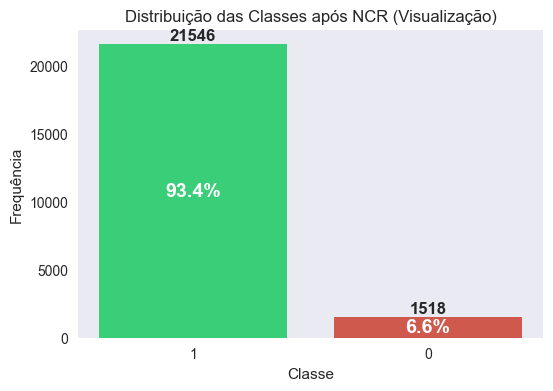

In [11]:
## Visualização da distribuição de classes apos aplicar o NCR
ncr_resampler_vis = NeighbourhoodCleaningRule(
    sampling_strategy='majority',
    n_neighbors=5,
    kind_sel='mode',
    n_jobs=-1
)

visualization_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor_clean),
    ('resampler', ncr_resampler_vis)
])

X_vis, y_vis = visualization_pipeline.fit_resample(X_train_clean, y_train)
counts = y_vis.value_counts()
proportions = y_vis.value_counts(normalize=True)

# Visualização gráfica
plt.figure(figsize=(6,4))
bars = plt.bar(counts.index.astype(str), counts.values, color=["#3ACE78", "#CE594C"])
plt.title("Distribuição das Classes após NCR (Visualização)")
plt.xlabel("Classe")
plt.ylabel("Frequência")
for bar, count, prop in zip(bars, counts.values, proportions.values):
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        bar.get_height()/2,
        f'{prop:.1%}', 
        ha='center', va='center', fontweight='bold', color='white', fontsize=14
    )
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        bar.get_height() + 50,
        f'{count}', 
        ha='center', va='bottom', fontweight='bold'
    )
plt.grid(False)
plt.show()

## 3. Seleção de Modelos Fase 

### 3.1 Fase 1

Modelos avaliados nesta fase:

- **K-NN** (K-Nearest Neighbors)
- **Árvore de Decisão** (Decision Tree)
- **Random Forest**
- **SVM** (Support Vector Machine)
- **LVQ** (Learning Vector Quantization)


In [12]:
models = {
    "K-NN": KNeighborsClassifier(),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM (Kernel RBF)": SVC(random_state=42, max_iter=1000, probability=True),
    "GMLVQ" : LVQ(random_state=42)
}

In [13]:
# Dicionário de métricas que queremos calcular
scoring = {
    'precision_0': make_scorer(precision_score, pos_label=0, zero_division=0),
    'precision_1': make_scorer(precision_score, pos_label=1, zero_division=0),
    'recall_0': make_scorer(recall_score, pos_label=0, zero_division=0),
    'recall_1': make_scorer(recall_score, pos_label=1, zero_division=0),
    'f1_0': make_scorer(f1_score, pos_label=0, zero_division=0),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Estratégia de validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dicionário para armazenar os resultados finais
results_clean = {}
results_full = {}
results_NCR = {}
resultS_full_NCR = {}


In [ ]:
# Loop para avaliar cada modelo do seu dicionário 'models'
for name, model in models.items():
    print(f"Avaliando : {name}...")
    
    # Criação do Pipeline Simples
    # Etapa 1: 'preprocessor_full'.
    # Etapa 2: O classificador.
    pipeline_full = Pipeline(steps=[
        ('preprocessor', preprocessor_clean),
        ('StandardScaler', StandardScaler()),
        ('classifier', model)
    ])
        # Executa a validação cruzada no pipeline
    # Os dados de treino são os originais e completos: X_train e y_train
    scores = cross_validate(
        pipeline_full, 
        X_train, 
        y_train,
        cv=cv_strategy, 
        scoring=scoring, 
        n_jobs=-1
    )
    
    # Armazena a média dos resultados
    results_full[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando : K-NN...
Avaliando : Árvore de Decisão...
Avaliando : Random Forest...
Avaliando : SVM (Kernel RBF)...
Avaliando : GMLVQ...


In [29]:
# Loop para avaliar cada modelo do seu dicionário 'models'
for name, model in models.items():
    print(f"Avaliando : {name}...")
    
    # Criação do Pipeline 
    pipeline_full_ncr =  create_pipeline(model, use_full = True)
    
    # Executa a validação cruzada no pipeline
    # Os dados de treino são os originais e completos: X_train e y_train
    scores = cross_validate(
        pipeline_full, 
        X_train, 
        y_train,
        cv=cv_strategy, 
        scoring=scoring, 
        n_jobs=-1
    )
    
    # Armazena a média dos resultados
    resultS_full_NCR[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando : K-NN...
Avaliando : Árvore de Decisão...
Avaliando : Random Forest...
Avaliando : SVM (Kernel RBF)...
Avaliando : GMLVQ...


In [30]:
# Loop para avaliar cada modelo do seu dicionário 'models'
for name, model in models.items():
    print(f"Avaliando X_train_clean: {name}...")
    
    # Criação do Pipeline Simples
    # Etapa 1: 'preprocessor_clean' que você já definiu.
    # Etapa 2: O classificador da vez.
    pipeline_clean = Pipeline(steps=[
        ('preprocessor', preprocessor_clean),
        ('StandardScaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Executa a validação cruzada no pipeline
    # Os dados de treino são X_train_clean e y_train
    scores = cross_validate(
        pipeline_clean, 
        X_train_clean, 
        y_train,
        cv=cv_strategy, 
        scoring=scoring, 
        n_jobs=-1
    )
    
    # Armazena a média dos resultados
    results_clean[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }


Avaliando X_train_clean: K-NN...
Avaliando X_train_clean: Árvore de Decisão...
Avaliando X_train_clean: Random Forest...
Avaliando X_train_clean: SVM (Kernel RBF)...
Avaliando X_train_clean: GMLVQ...


In [31]:
# Loop de avaliação
for name, model in models.items():
    print(f"Avaliando com Resampling (NCR): {name}...")
    
    # Criamos o pipeline com colunas limpas (use_full=False) 
    # e COM reamostragem (use_resampling=True)
    pipeline = create_pipeline(model, use_full=False)
    
    scores = cross_validate(
        pipeline,
        X_train_clean,  # Usamos os dados originais, o pipeline cuida do resto
        y_train,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1
    )
    
    results_NCR[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando com Resampling (NCR): K-NN...
Avaliando com Resampling (NCR): Árvore de Decisão...
Avaliando com Resampling (NCR): Random Forest...
Avaliando com Resampling (NCR): SVM (Kernel RBF)...
Avaliando com Resampling (NCR): GMLVQ...


In [32]:
# --- Visualização dos Resultados ---
results_full_df = pd.DataFrame(results_full).T
results_full_df = results_full_df.sort_values(by='f1_0_media', ascending=False)
print("\n" + "=" * 60)
print("       RESULTADO BASELINE (DADOS COMPLETOS E SEM RESAMPLING)")
print("=" * 60)
print(results_full_df)


       RESULTADO BASELINE (DADOS COMPLETOS E SEM RESAMPLING)
                   precision_0_media  precision_1_media  recall_0_media  \
K-NN                        0.521184           0.955924        0.260874   
Random Forest               0.457719           0.951419        0.180489   
Árvore de Decisão           0.325849           0.951873        0.198265   
SVM (Kernel RBF)            0.293134           0.944455        0.052037   
GMLVQ                       0.092787           0.942954        0.037541   

                   recall_1_media  f1_0_media  f1_weighted_media  
K-NN                     0.985221    0.346910           0.934248  
Random Forest            0.986435    0.257519           0.927432  
Árvore de Decisão        0.974531    0.245355           0.921504  
SVM (Kernel RBF)         0.990728    0.086355           0.916037  
GMLVQ                    0.977690    0.049676           0.907252  


In [36]:
# --- Visualização dos Resultados ---
results_full_ncr_df = pd.DataFrame(resultS_full_NCR).T
results_full_ncr_df = results_full_ncr_df.sort_values(by='f1_0_media', ascending=False)
print("\n" + "=" * 60)
print("       RESULTADO BASELINE (DADOS COMPLETOS E COM RESAMPLING)")
print("=" * 60)
print(results_full_ncr_df)


       RESULTADO BASELINE (DADOS COMPLETOS E COM RESAMPLING)
                   precision_0_media  precision_1_media  recall_0_media  \
K-NN                        0.092787           0.942954        0.037541   
Árvore de Decisão           0.092787           0.942954        0.037541   
Random Forest               0.092787           0.942954        0.037541   
SVM (Kernel RBF)            0.092787           0.942954        0.037541   
GMLVQ                       0.092787           0.942954        0.037541   

                   recall_1_media  f1_0_media  f1_weighted_media  
K-NN                      0.97769    0.049676           0.907252  
Árvore de Decisão         0.97769    0.049676           0.907252  
Random Forest             0.97769    0.049676           0.907252  
SVM (Kernel RBF)          0.97769    0.049676           0.907252  
GMLVQ                     0.97769    0.049676           0.907252  


In [34]:
# --- Visualização dos Resultados ---
results_clean_df = pd.DataFrame(results_clean).T
results_clean_df = results_clean_df.sort_values(by='f1_0_media', ascending=False)

print("\n" + "=" * 60)
print("     RESULTADO BASELINE (DADOS COM COLUNAS REMOVIDAS E SEM RESAMPLING)")
print("=" * 60)
print(results_clean_df)


     RESULTADO BASELINE (DADOS COM COLUNAS REMOVIDAS E SEM RESAMPLING)
                   precision_0_media  precision_1_media  recall_0_media  \
K-NN                        0.515937           0.956302        0.268111   
Random Forest               0.430600           0.951214        0.177853   
Árvore de Decisão           0.326602           0.951475        0.190364   
SVM (Kernel RBF)            0.365191           0.944385        0.046769   
GMLVQ                       0.093300           0.942806        0.037563   

                   recall_1_media  f1_0_media  f1_weighted_media  
K-NN                     0.984451    0.352397           0.934399  
Random Forest            0.985221    0.250426           0.926369  
Árvore de Decisão        0.975665    0.239467           0.921493  
SVM (Kernel RBF)         0.994898    0.082570           0.917655  
GMLVQ                    0.975140    0.050747           0.906092  


In [38]:
results_NCR_df = pd.DataFrame(results_NCR).T
results_NCR_df = results_NCR_df.sort_values(by='f1_0_media', ascending=False)

print("\n" + "=" * 60)
print("      RESULTADO BASELINE (DADOS COM COLUNAS REMOVIDAS E COM RESAMPLING)")
print("=" * 60)
print(results_NCR_df)


      RESULTADO BASELINE (DADOS COM COLUNAS REMOVIDAS E COM RESAMPLING)
                   precision_0_media  precision_1_media  recall_0_media  \
Random Forest               0.366296           0.967232        0.476954   
K-NN                        0.345195           0.963256        0.409065   
Árvore de Decisão           0.302059           0.966993        0.482906   
SVM (Kernel RBF)            0.259208           0.948430        0.140268   
GMLVQ                       0.163064           0.943731        0.049418   

                   recall_1_media  f1_0_media  f1_weighted_media  
Random Forest            0.948941    0.413806           0.926479  
K-NN                     0.951978    0.373580           0.923757  
Árvore de Decisão        0.931165    0.371351           0.915297  
SVM (Kernel RBF)         0.971493    0.172785           0.914205  
GMLVQ                    0.979917    0.070110           0.909817  


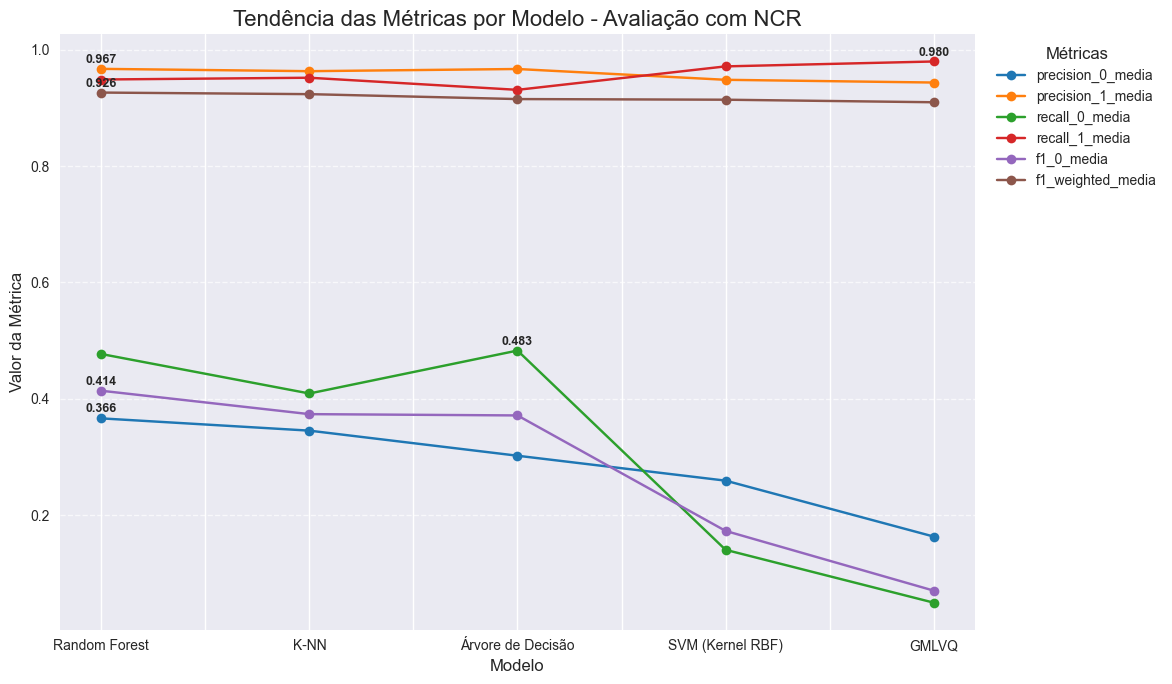

In [39]:
# --- Dicionário de cores para as MÉTRICAS ---
cores_metricas = {
    'precision_0_media': '#1f77b4',  # Azul
    'precision_1_media': '#ff7f0e',  # Laranja
    'recall_0_media':    '#2ca02c',  # Verde
    'recall_1_media':    '#d62728',  # Vermelho
    'f1_0_media':        '#9467bd',  # Roxo
    'f1_weighted_media': '#8c564b'   # Marrom
}


# --- Criação do Gráfico ---
fig, ax = plt.subplots(figsize=(14, 7))

# Plotamos o DataFrame, passando o novo dicionário de cores
results_NCR_df.plot(
    kind='line',
    marker='o',
    ax=ax,
    color=cores_metricas  
)

# --- Loop para anotar o ponto de maior valor de cada métrica ---
for metrica in results_NCR_df.columns:
    serie_metrica = results_NCR_df[metrica]
    max_valor = serie_metrica.max()
    max_modelo = serie_metrica.idxmax()
    pos_x = list(results_NCR_df.index).index(max_modelo)
    
    ax.text(
        pos_x,
        max_valor + 0.005,
        f'{max_valor:.3f}',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=9
    )

# --- Customização final do Gráfico ---
plt.title('Tendência das Métricas por Modelo - Avaliação com NCR', fontsize=16)
plt.ylabel('Valor da Métrica', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Métricas', bbox_to_anchor=(1.01, 1), loc='upper left') 
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

### 3.2 Fase 2

- **Rede Neural MLP (Multilayer Perceptron)**
- **Comitê de Redes Neurais Artificiais**
- **Comitê Heterogêneo (Stacking)**
- **XGBoost**
- **LightGBM**


In [40]:

models_fase2 = {
    "MLP": MLPClassifier(random_state=42, max_iter=300),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1)
    }

# --- Comitê de Redes Neurais (Voting) ---
mlp1 = MLPClassifier(random_state=1, max_iter=300)
mlp2 = MLPClassifier(random_state=2, max_iter=300)
mlp3 = MLPClassifier(random_state=3, max_iter=300)
voting_mlp = VotingClassifier(
    estimators=[('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp3)],
    voting='soft',
    n_jobs=-1
)

# --- Comitê Heterogêneo (Stacking) ---
estimators_stacking = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('mlp', MLPClassifier(random_state=42, max_iter=300))
]
stacking_committee = StackingClassifier(
    estimators=estimators_stacking,
    final_estimator=RandomForestClassifier(random_state=43),
    cv=cv_strategy,
    n_jobs=-1
)

# Dicionário com os modelos de comitê para avaliação
committee_models = {
    "Comitê MLPs (Voting)": voting_mlp,
    "Comitê Heterogêneo (Stacking)": stacking_committee
}


results_fase2 = {}

In [46]:
# Loop para avaliar cada modelo da Fase 2
for name, model in models_fase2.items():
    print(f"Avaliando modelo baseline: {name}...")


    pipeline = create_pipeline(model, use_full=False)

    # Executa a validação cruzada no pipeline com os dados limpos
    scores = cross_validate(
        pipeline,
        X_train_clean,
        y_train,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1
    )

    # Armazena a média dos resultados
    results_fase2[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando modelo baseline: MLP...
Avaliando modelo baseline: XGBoost...
Avaliando modelo baseline: LightGBM...


In [47]:
# Loop para avaliar cada modelo de comitês
for name, model in committee_models.items():
    print(f"Avaliando modelo baseline: {name}...")

    pipeline = create_pipeline(model, use_full=False)

    # Executa a validação cruzada no pipeline com os dados limpos
    scores = cross_validate(
        pipeline,
        X_train_clean,
        y_train,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1
    )

    # Armazena a média dos resultados
    results_fase2[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando modelo baseline: Comitê MLPs (Voting)...
Avaliando modelo baseline: Comitê Heterogêneo (Stacking)...


In [48]:
# --- Visualização dos Resultados em DataFrame ---
results_fase2_df = pd.DataFrame(results_fase2).T
results_fase2_df = results_fase2_df.sort_values(by='f1_0_media', ascending=False)

print("\n" + "=" * 80)
print("             RESULTADO BASELINE DA FASE 2 COM RESAMPLING")
print("=" * 80)
print(results_fase2_df)


             RESULTADO BASELINE DA FASE 2 COM RESAMPLING
                               precision_0_media  precision_1_media  \
XGBoost                                 0.408435           0.964159   
Comitê Heterogêneo (Stacking)           0.332463           0.965699   
LightGBM                                0.373724           0.953342   
Comitê MLPs (Voting)                    0.400291           0.949736   
MLP                                     0.375068           0.949686   

                               recall_0_media  recall_1_media  f1_0_media  \
XGBoost                              0.417681        0.962586    0.411880   
Comitê Heterogêneo (Stacking)        0.454562        0.943515    0.383003   
LightGBM                             0.221997        0.977001    0.277760   
Comitê MLPs (Voting)                 0.150821        0.986112    0.218295   
MLP                                  0.151498        0.984371    0.215416   

                               f1_weighted_media  
X

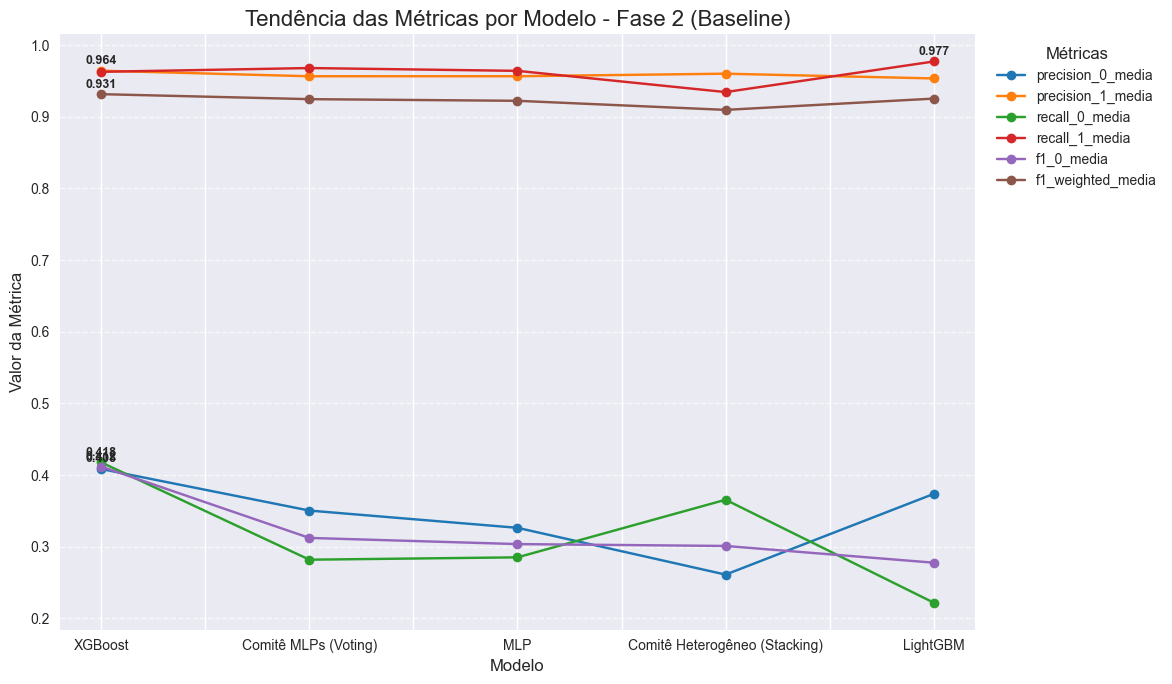

In [44]:
# --- Dicionário de cores para as MÉTRICAS ---
cores_metricas = {
    'precision_0_media': '#1f77b4',  # Azul
    'precision_1_media': '#ff7f0e',  # Laranja
    'recall_0_media':    '#2ca02c',  # Verde
    'recall_1_media':    '#d62728',  # Vermelho
    'f1_0_media':        '#9467bd',  # Roxo
    'f1_weighted_media': '#8c564b'   # Marrom
}

# --- Criação do Gráfico ---
fig, ax = plt.subplots(figsize=(14, 7))

results_fase2_df.plot(
    kind='line',
    marker='o',
    ax=ax,
    color=cores_metricas  
)

# --- Loop para anotar o ponto de maior valor de cada métrica ---
for metrica in results_fase2_df.columns:
    serie_metrica = results_fase2_df[metrica]
    
    max_valor = serie_metrica.max()
    max_modelo = serie_metrica.idxmax()
    
    pos_x = list(results_fase2_df.index).index(max_modelo)
    
    ax.text(
        pos_x,
        max_valor + 0.005,
        f'{max_valor:.3f}',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=9
    )

# --- Customização final do Gráfico ---
plt.title('Tendência das Métricas por Modelo - Fase 2 (Baseline)', fontsize=16)
plt.ylabel('Valor da Métrica', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Métricas', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

## 4. Busca de Hiperparâmetros

### 4.1 Fase 1

Modelos avaliados nesta fase:

- **K-NN** (K-Nearest Neighbors)
- **Árvore de Decisão** (Decision Tree)
- **SVM** (Support Vector Machine)
- **Random Forest**
- **LVQ** (Learning Vector Quantization)


In [50]:
# --- Dicionário com as Distribuições de Hiperparâmetros ---
param_distributions = {
    "K-NN": {
        'classifier__n_neighbors': randint(3, 30),
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    "Árvore de Decisão": {
        'classifier__max_depth': randint(3, 21),
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 11),
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__class_weight': ['balanced', None]
    },
    "Random Forest": {
        'classifier__n_estimators': randint(50, 301),
        'classifier__max_depth': randint(3, 21),
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 11),
        'classifier__max_features': ['sqrt', 'log2', None],
        'classifier__class_weight': ['balanced', None],
        'classifier__bootstrap': [True, False]
    },
    "SVM (Kernel RBF)": {
        'classifier__C': loguniform(0.1, 100),
        'classifier__gamma': loguniform(0.001, 1),
        'classifier__kernel': ['rbf'],
        'classifier__class_weight': ['balanced', None]
    },
    "GMLVQ": {
        "classifier__prototype_n_per_class": [1, 2], 
        "classifier__solver_type": ["steepest-gradient-descent", "waypoint-gradient-descent"],
        "classifier__distance_type": ["adaptive-squared-euclidean"],
        "classifier__activation_type": ["identity", "sigmoid", "soft+"],
        "classifier__solver_params": [{"step_size": s} for s in [0.1, 0.01]]
    }
}

In [ ]:
# Dicionário para armazenar os resultados detalhados de todas as iterações
all_results_fase1 = {}

# Número de iterações da nossa simulação para cada modelo
n_sim_iterations = 20

# Loop principal para otimizar cada modelo
for name, model in models.items():
    print(f"--> Otimizando o modelo: {name}")
    
    iteration_best_scores = []  # O melhor score de cada busca
    iteration_mean_scores = []  # A média do CV do melhor estimador de cada busca
    iteration_std_scores = []   # O desvio padrão do CV do melhor estimador de cada busca
    iteration_params = []       # Os melhores parâmetros de cada busca
    
    best_overall_score = -1 # Para rastrear o melhor score geral e salvar o melhor modelo
    
    # Loop para executar múltiplas simulações da busca
    for iteration in range(n_sim_iterations):
        print(f"    Iniciando iteração {iteration+1}/{n_sim_iterations} para {name}...")

        # Ajusta o n_iter para modelos mais lentos
        if name in ["Random Forest", "SVM (Kernel RBF)", "GMLVQ"]:
            n_iter_search = 5
        else:
            n_iter_search = 10

        # Cria o pipeline com pré-processamento e reamostragem
        pipeline = create_pipeline(model, use_full=False)

        # Configura a busca aleatória de hiperparâmetros
        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_distributions[name],
            n_iter=n_iter_search,
            cv=cv_strategy,
            scoring=scoring['f1_0'],  # Métrica correta
            n_jobs=-1,
            random_state=42 + iteration, # Seed diferente para cada simulação
            verbose=2
        )

        # Executa a busca nos dados de treino 
        random_search.fit(X_train_clean, y_train)
        
        # --- Captura dos resultados detalhados ---
        best_index = random_search.best_index_
        mean_cv_score = random_search.cv_results_['mean_test_score'][best_index]
        std_cv_score = random_search.cv_results_['std_test_score'][best_index]
        
        # Armazena os resultados desta simulação
        iteration_best_scores.append(random_search.best_score_)
        iteration_mean_scores.append(mean_cv_score)
        iteration_std_scores.append(std_cv_score)
        iteration_params.append(random_search.best_params_)
        
        print(f"        -> Iteração {iteration+1}: Best F1-Score (classe 0): {random_search.best_score_:.4f}")
        print(f"        -> Parâmetros: {random_search.best_params_}")
        print(f"        -> Média CV: {mean_cv_score:.4f} | Desvio CV: {std_cv_score:.4f}")

        # Salva o melhor modelo encontrado até agora
        if random_search.best_score_ > best_overall_score:
            best_overall_score = random_search.best_score_
            joblib.dump(random_search.best_estimator_, f'modelos/{name}_otimizado.pkl')
            print(f"        -> Novo melhor modelo salvo para '{name}' (F1-Score: {best_overall_score:.4f})")
    
    # Armazena todos os resultados para este modelo
    all_results_fase1[name] = {
        'best_scores': iteration_best_scores,
        'mean_scores': iteration_mean_scores,
        'std_scores': iteration_std_scores,
        'params': iteration_params,
        'overall_best_score': best_overall_score,
        'overall_best_params': iteration_params[np.argmax(iteration_best_scores)]
    }
    
    # Resumo dos resultados para este modelo
    print(f"\n    Otimização de '{name}' concluída.")
    print(f"    Melhor F1-Score (classe 0) encontrado: {best_overall_score:.4f}")
    print(f"    Melhores Parâmetros: {all_results_fase1[name]['overall_best_params']}")
    print("-" * 70)

--> Otimizando o modelo: K-NN
    Iniciando iteração 1/20 para K-NN...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
        -> Iteração 1: Best F1-Score (classe 0): 0.3706
        -> Parâmetros: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 13, 'classifier__weights': 'distance'}
        -> Média CV: 0.3706 | Desvio CV: 0.0201
        -> Novo melhor modelo salvo para 'K-NN' (F1-Score: 0.3706)
    Iniciando iteração 2/20 para K-NN...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
        -> Iteração 2: Best F1-Score (classe 0): 0.3791
        -> Parâmetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
        -> Média CV: 0.3791 | Desvio CV: 0.0167
        -> Novo melhor modelo salvo para 'K-NN' (F1-Score: 0.3791)
    Iniciando iteração 3/20 para K-NN...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
        -> Iteração 3: Best F1-Score (classe 0): 0.3813
        -> Parâmet

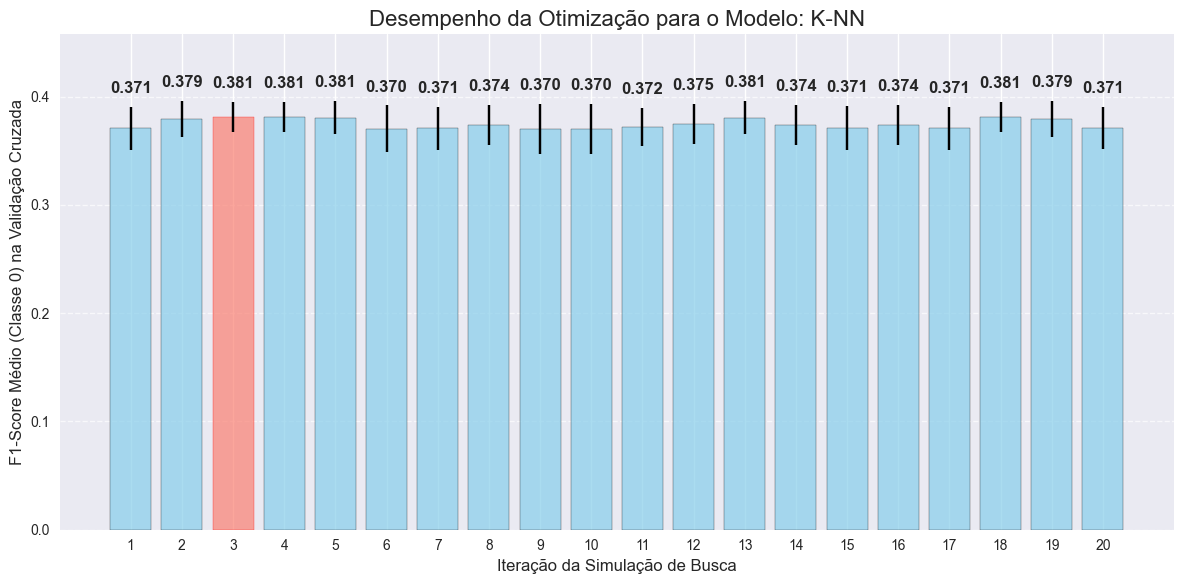

Melhores Parâmetros Gerais para 'K-NN':
{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 6, 'classifier__weights': 'uniform'}
----------------------------------------------------------------------


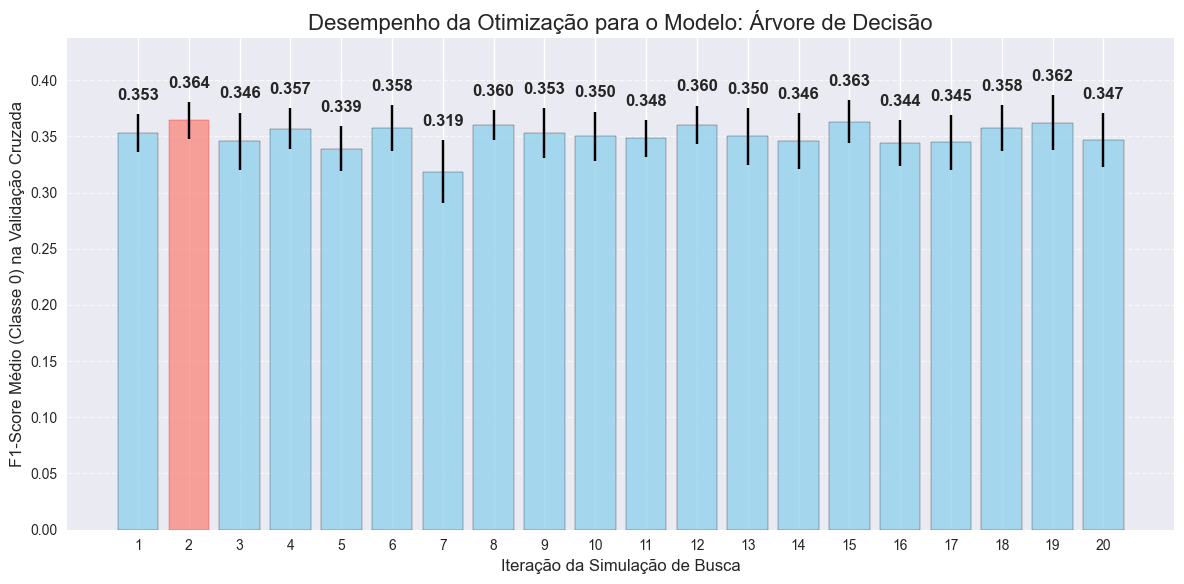

Melhores Parâmetros Gerais para 'Árvore de Decisão':
{'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 19, 'classifier__min_samples_leaf': 7, 'classifier__min_samples_split': 7}
----------------------------------------------------------------------


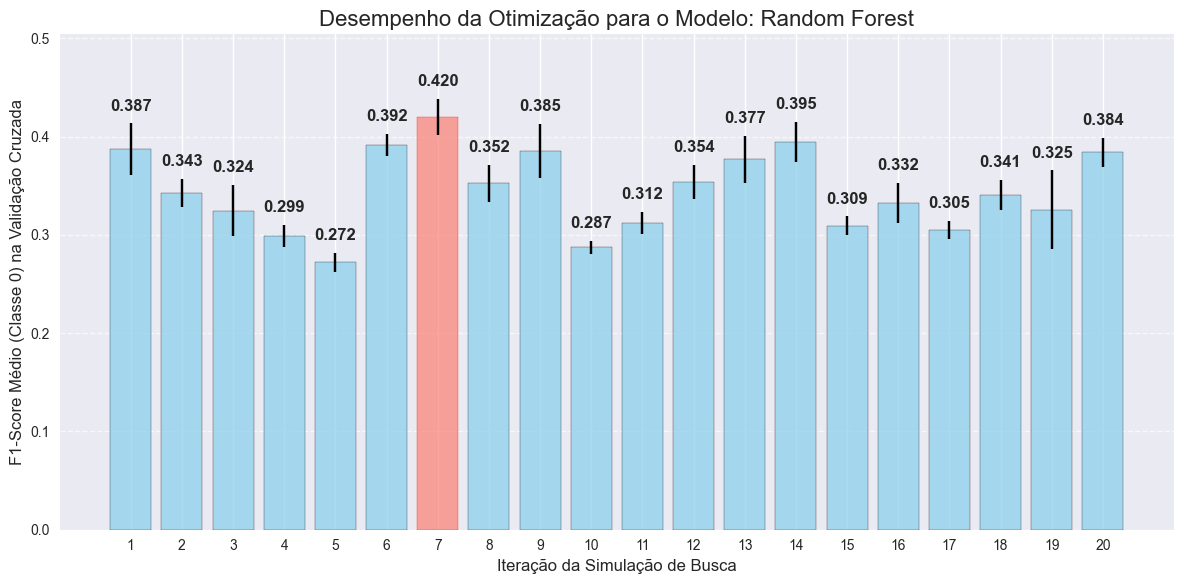

Melhores Parâmetros Gerais para 'Random Forest':
{'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 248}
----------------------------------------------------------------------


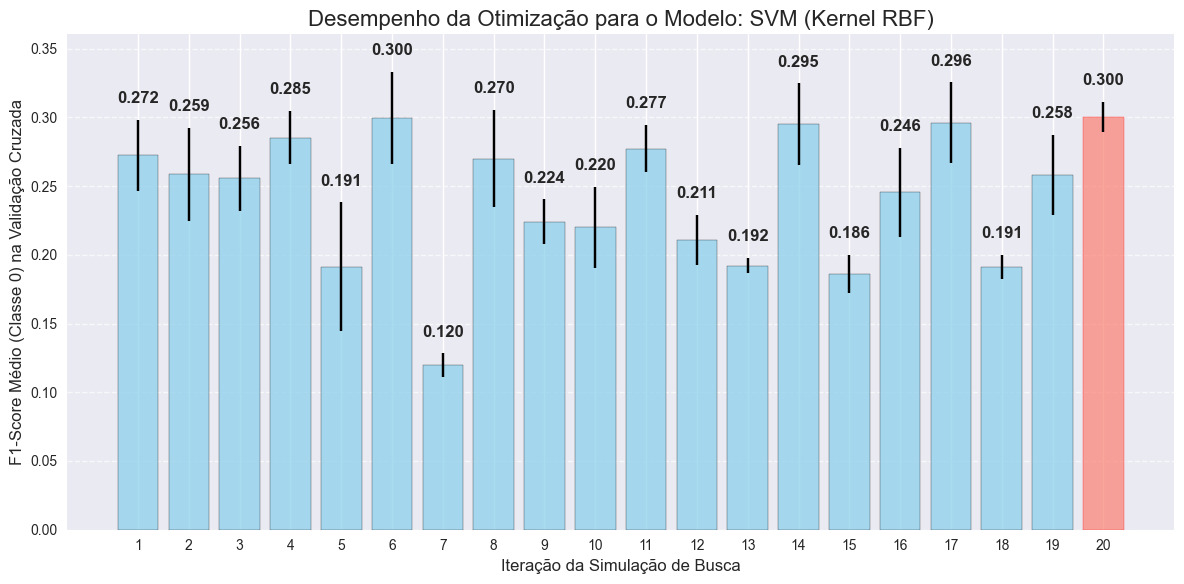

Melhores Parâmetros Gerais para 'SVM (Kernel RBF)':
{'classifier__C': np.float64(4.2364269744927086), 'classifier__class_weight': None, 'classifier__gamma': np.float64(0.7848366939245486), 'classifier__kernel': 'rbf'}
----------------------------------------------------------------------


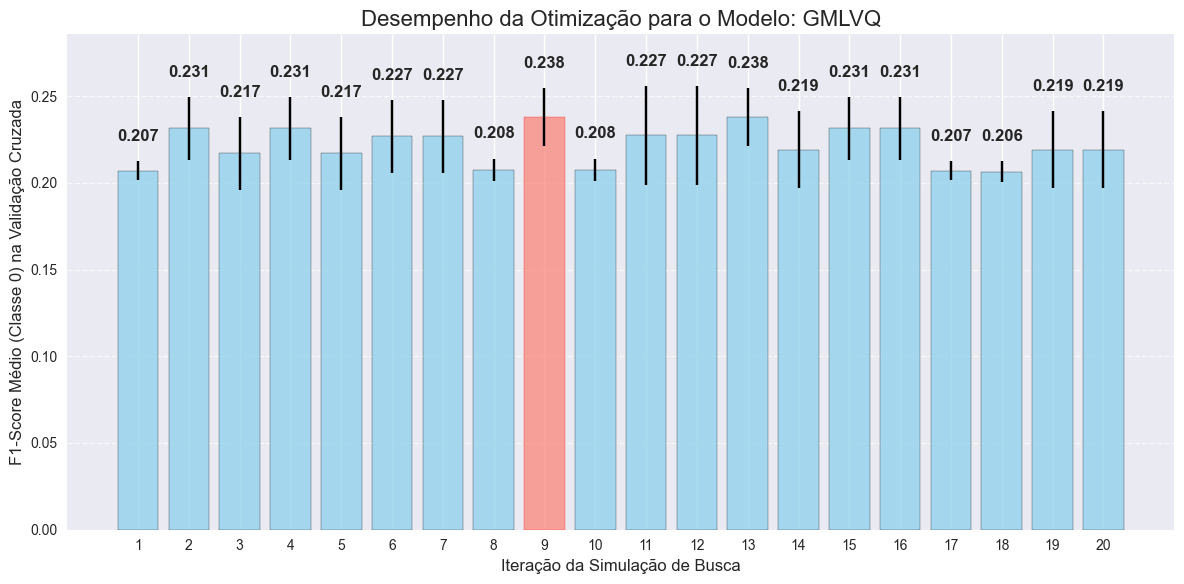

Melhores Parâmetros Gerais para 'GMLVQ':
{'classifier__solver_type': 'waypoint-gradient-descent', 'classifier__solver_params': {'step_size': 0.1}, 'classifier__prototype_n_per_class': 2, 'classifier__distance_type': 'adaptive-squared-euclidean', 'classifier__activation_type': 'soft+'}
----------------------------------------------------------------------


In [52]:
# Loop para gerar um gráfico para cada modelo otimizado
for name, results in all_results_fase1.items():
    mean_scores = results['mean_scores']
    std_scores = results['std_scores']
    iterations = np.arange(1, len(mean_scores) + 1)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        iterations,
        mean_scores,
        yerr=std_scores,
        capsize=5,
        alpha=0.7,
        color='skyblue',
        edgecolor='black'
    )

    best_iter_index = np.argmax(mean_scores)
    bars[best_iter_index].set_color('salmon')
    bars[best_iter_index].set_edgecolor('red')

    plt.title(f'Desempenho da Otimização para o Modelo: {name}', fontsize=16)
    plt.xlabel('Iteração da Simulação de Busca', fontsize=12)
    plt.ylabel('F1-Score Médio (Classe 0) na Validação Cruzada', fontsize=12)
    plt.xticks(iterations)
    plt.ylim(0, max(mean_scores) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adiciona o valor médio no centro da barra, acima do topo da barra de erro
    for idx, bar in enumerate(bars):
        yval = bar.get_height()
        err = std_scores[idx]
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval + err + 0.01,
            f'{yval:.3f}',
            ha='center',
            va='bottom',
            fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

    print(f"Melhores Parâmetros Gerais para '{name}':")
    print(results['overall_best_params'])
    print("-" * 70)

### 4.2 Fase 2

Nesta etapa, foram avaliados os seguintes modelos:

- **Rede Neural MLP (Multilayer Perceptron)**
- **Comitê de Redes Neurais Artificiais (Voting MLPs)**
- **Comitê Heterogêneo (Stacking)**
- **XGBoost**
- **LightGBM**



In [87]:
# --- Dicionário de Hiperparâmetros para os modelos da FASE 2  ---
param_distributions_fase2 = {
    "XGBoost": {
        'classifier__n_estimators': randint(50, 300),
        'classifier__max_depth': randint(3, 15),
        'classifier__learning_rate': loguniform(0.01, 0.3),
        'classifier__subsample': loguniform(0.6, 1.0),
        'classifier__colsample_bytree': loguniform(0.6, 1.0),
        'classifier__gamma': loguniform(1e-4, 5.0),
        'classifier__reg_alpha': loguniform(1e-4, 1.0),  
        'classifier__reg_lambda': loguniform(1e-4, 1.0) 
    },
    "LightGBM": {
        'classifier__n_estimators': randint(50, 300),
        'classifier__max_depth': randint(3, 15),
        'classifier__learning_rate': loguniform(0.01, 0.3),
        'classifier__num_leaves': randint(20, 100),        
        'classifier__subsample': loguniform(0.6, 1.0),      
        'classifier__colsample_bytree': loguniform(0.6, 1.0),
        'classifier__reg_alpha': loguniform(1e-4, 1.0),     
        'classifier__reg_lambda': loguniform(1e-4, 1.0)     
    },
    "MLP": {
        'classifier__hidden_layer_sizes': [
            (50,), (100,),               # 1 Camada
            (50, 50), (100, 50),         # 2 Camadas
            (100, 50, 25),               # 3 Camadas (nova)
            (50, 50, 50),                # 3 Camadas (nova)
            (100, 100, 50)               # 3 Camadas (nova)
        ],
        'classifier__activation': ['tanh', 'relu'],
        'classifier__solver': ['adam', 'sgd'],
        'classifier__alpha': loguniform(1e-5, 1e-1), # Regularização
        'classifier__learning_rate': ['constant', 'adaptive']
    }
}

In [89]:
# Dicionário para armazenar os resultados detalhados de todas as iterações
all_results_fase2 = {}

# Número de iterações da nossa simulação para cada modelo
n_sim_iterations = 20

# Loop principal para otimizar cada modelo da Fase 2
for name, model in models_fase2.items():
    print(f"--> Otimizando o modelo: {name}")
    
    # Listas para armazenar resultados de cada simulação
    iteration_best_scores = []
    iteration_mean_scores = []
    iteration_std_scores = []
    iteration_params = []
    
    best_overall_score = -1
    
    # Loop para executar múltiplas simulações da busca
    for iteration in range(n_sim_iterations):
        print(f"    Iniciando iteração {iteration+1}/{n_sim_iterations} para {name}...")

        # Ajusta o n_iter para o MLP, que é mais lento
        if name == "MLP":
            n_iter_search = 3
        else:
            n_iter_search = 10

        # Cria o pipeline com pré-processamento e reamostragem
        pipeline = create_pipeline(model, use_full=False)

        # Configura a busca aleatória de hiperparâmetros
        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_distributions_fase2[name],
            n_iter=n_iter_search,
            cv=cv_strategy,
            scoring=scoring['f1_0'],
            n_jobs=-1,
            random_state=42 + iteration,
            verbose=0
        )

        # Executa a busca nos dados de treino
        random_search.fit(X_train_clean, y_train)
        
        # Captura dos resultados detalhados
        best_index = random_search.best_index_
        mean_cv_score = random_search.cv_results_['mean_test_score'][best_index]
        std_cv_score = random_search.cv_results_['std_test_score'][best_index]
        
        # Armazena os resultados
        iteration_best_scores.append(random_search.best_score_)
        iteration_mean_scores.append(mean_cv_score)
        iteration_std_scores.append(std_cv_score)
        iteration_params.append(random_search.best_params_)
        
        print(f"        -> Iteração {iteration+1}: Best F1-Score (classe 0): {random_search.best_score_:.4f}")
        print(f"        -> Parâmetros: {random_search.best_params_}")
        print(f"        -> Média CV: {mean_cv_score:.4f} | Desvio CV: {std_cv_score:.4f}")

        # Salva o melhor modelo encontrado até agora
        if random_search.best_score_ > best_overall_score:
            best_overall_score = random_search.best_score_
            joblib.dump(random_search.best_estimator_, f'modelos/{name}_otimizado.pkl')
            print(f"        -> Novo melhor modelo salvo para '{name}' (F1-Score: {best_overall_score:.4f})")
    
    # Armazena todos os resultados para este modelo
    all_results_fase2[name] = {
        'best_scores': iteration_best_scores,
        'mean_scores': iteration_mean_scores,
        'std_scores': iteration_std_scores,
        'params': iteration_params,
        'overall_best_score': best_overall_score,
        'overall_best_params': iteration_params[np.argmax(iteration_best_scores)]
    }
    
    # Resumo dos resultados para este modelo
    print(f"\n    Otimização de '{name}' concluída.")
    print(f"    Melhor F1-Score (classe 0) encontrado: {best_overall_score:.4f}")
    print(f"    Melhores Parâmetros: {all_results_fase2[name]['overall_best_params']}")
    print("-" * 70)

--> Otimizando o modelo: MLP
    Iniciando iteração 1/20 para MLP...
        -> Iteração 1: Best F1-Score (classe 0): 0.3148
        -> Parâmetros: {'classifier__activation': 'tanh', 'classifier__alpha': np.float64(0.0024400607090817534), 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}
        -> Média CV: 0.3148 | Desvio CV: 0.0248
        -> Novo melhor modelo salvo para 'MLP' (F1-Score: 0.3148)
    Iniciando iteração 2/20 para MLP...
        -> Iteração 2: Best F1-Score (classe 0): 0.3133
        -> Parâmetros: {'classifier__activation': 'tanh', 'classifier__alpha': np.float64(4.881240952336934e-05), 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'adam'}
        -> Média CV: 0.3133 | Desvio CV: 0.0270
    Iniciando iteração 3/20 para MLP...
        -> Iteração 3: Best F1-Score (classe 0): 0.3013
        -> Parâmetros: {'classifier__activation': 'tanh', 'class

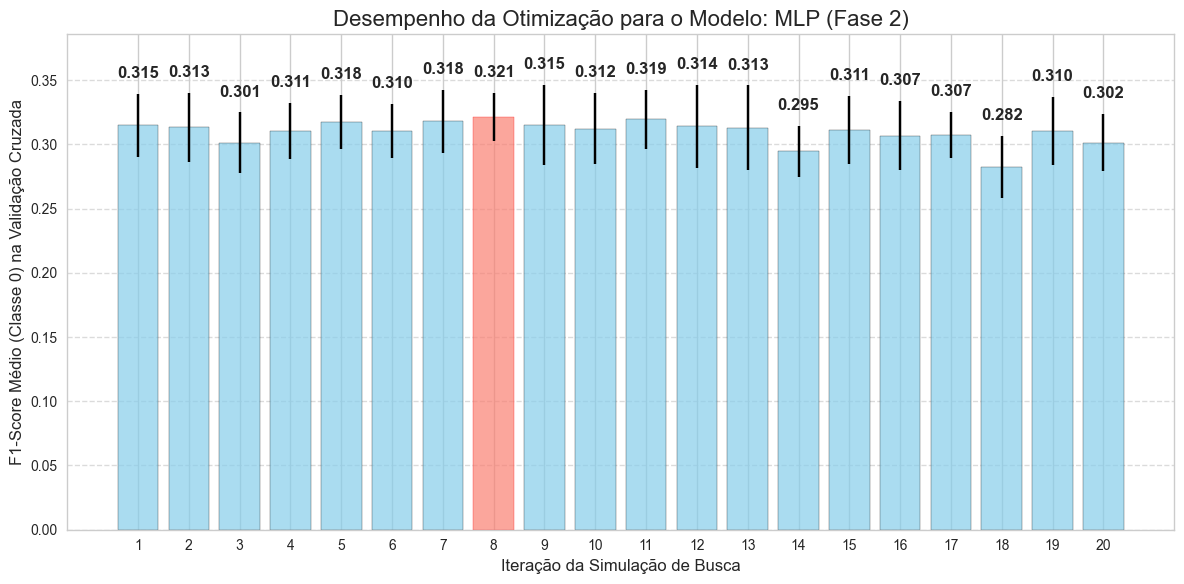

Melhores Parâmetros Gerais para 'MLP':
{'classifier__activation': 'tanh', 'classifier__alpha': np.float64(0.011233598319370477), 'classifier__hidden_layer_sizes': (50, 50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}
----------------------------------------------------------------------


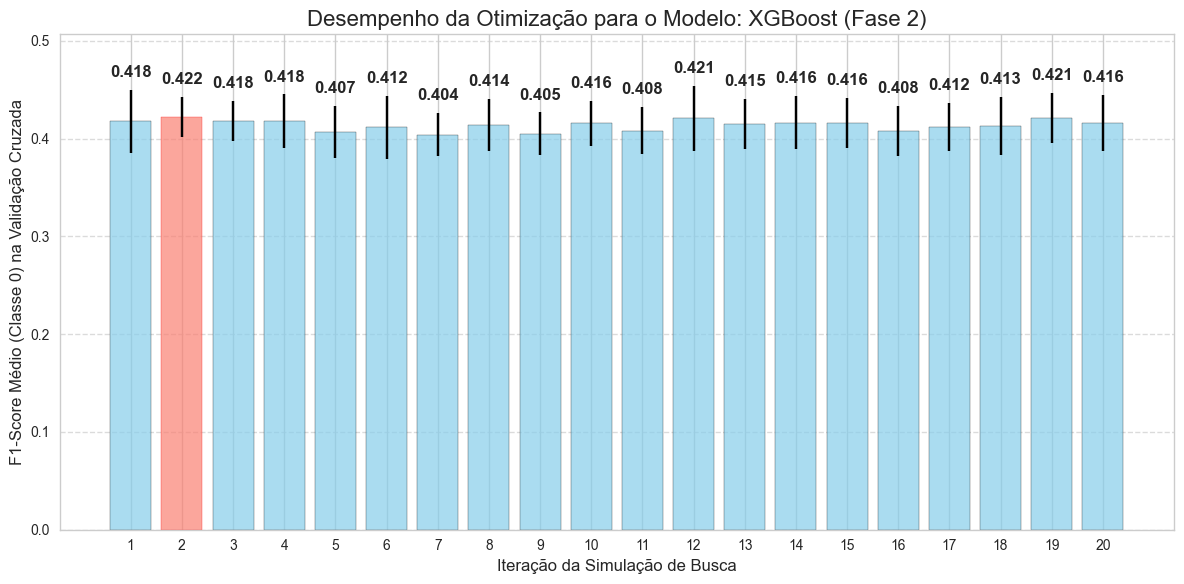

Melhores Parâmetros Gerais para 'XGBoost':
{'classifier__colsample_bytree': np.float64(0.7022164989230112), 'classifier__gamma': np.float64(0.06951946008790896), 'classifier__learning_rate': np.float64(0.14004622651042972), 'classifier__max_depth': 9, 'classifier__n_estimators': 194, 'classifier__reg_alpha': np.float64(0.018234869311881036), 'classifier__reg_lambda': np.float64(0.00015954403860183396), 'classifier__subsample': np.float64(0.7498890160380371)}
----------------------------------------------------------------------


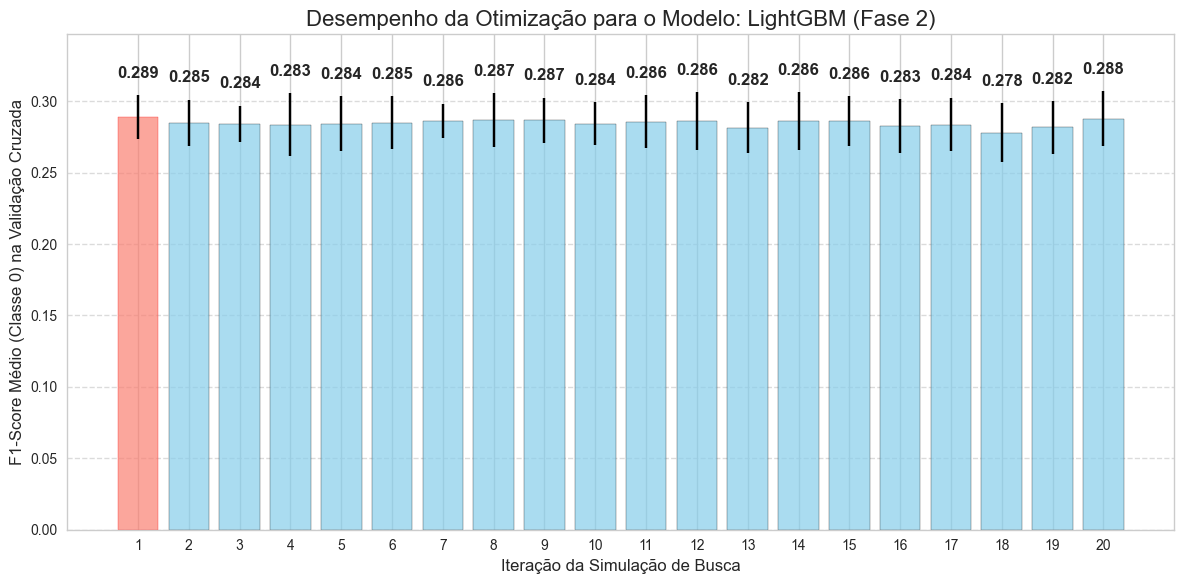

Melhores Parâmetros Gerais para 'LightGBM':
{'classifier__colsample_bytree': np.float64(0.8193665800680516), 'classifier__learning_rate': np.float64(0.170110026976697), 'classifier__max_depth': 5, 'classifier__n_estimators': 255, 'classifier__num_leaves': 55, 'classifier__reg_alpha': np.float64(0.000535728006960183), 'classifier__reg_lambda': np.float64(0.10506199451597038), 'classifier__subsample': np.float64(0.745541030315064)}
----------------------------------------------------------------------


In [90]:
# Loop para gerar um gráfico para cada modelo otimizado
for name, results in all_results_fase2.items():
    mean_scores = results['mean_scores']
    std_scores = results['std_scores']
    iterations = np.arange(1, len(mean_scores) + 1)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        iterations,
        mean_scores,
        yerr=std_scores,
        capsize=5,
        alpha=0.7,
        color='skyblue',
        edgecolor='black'
    )

    best_iter_index = np.argmax(mean_scores)
    bars[best_iter_index].set_color('salmon')
    bars[best_iter_index].set_edgecolor('red')

    plt.title(f'Desempenho da Otimização para o Modelo: {name} (Fase 2)', fontsize=16)
    plt.xlabel('Iteração da Simulação de Busca', fontsize=12)
    plt.ylabel('F1-Score Médio (Classe 0) na Validação Cruzada', fontsize=12)
    plt.xticks(iterations)
    plt.ylim(0, max(mean_scores) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adiciona o valor médio acima do topo da barra de erro
    for idx, bar in enumerate(bars):
        yval = bar.get_height()
        err = std_scores[idx]
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval + err + 0.01,
            f'{yval:.3f}',
            ha='center',
            va='bottom',
            fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

    print(f"Melhores Parâmetros Gerais para '{name}':")
    print(results['overall_best_params'])
    print("-" * 70)

### 4.3 Avaliação do Comitê Heterogêneo (Stacking) e Comitê de MLPs (Voting)

Nesta etapa, utilizamos o StackingClassifier para combinar os melhores modelos otimizados das fases anteriores: XGBoost, Random Forest e MLP. O objetivo é avaliar se a combinação desses algoritmos, por meio de um comitê heterogêneo, resulta em melhor desempenho preditivo para o problema de acesso a recursos da Amazon.


In [10]:
# Dicionário para armazenar os melhores modelos carregados da Fase 2
best_models_fase2 = {}
model_names_fase2 = ["MLP", "XGBoost", "LightGBM"]

print("Carregando modelos otimizados da Fase 2...")
for name in model_names_fase2:
    try:
        best_models_fase2[name] = joblib.load(f'modelos/{name}_otimizado.pkl')
        print(f"  - Modelo '{name}' carregado com sucesso.")
    except FileNotFoundError:
        print(f"  - AVISO: Modelo '{name}_otimizado.pkl' não encontrado.")

# Inclui o comitê de MLPs (Voting)
best_models_fase2["Comitê MLPs (Voting)"] = joblib.load('modelos/comite_mlp_final.pkl')
print("  - Comitê MLPs (Voting) carregado com sucesso.")

# Inclui o Stacking model
best_models_fase2["Stacking"] = joblib.load('modelos/stacking_model_otimizado.pkl')
print("  - Stacking model carregado com sucesso.")


Carregando modelos otimizados da Fase 2...
  - Modelo 'MLP' carregado com sucesso.
  - Modelo 'XGBoost' carregado com sucesso.
  - Modelo 'LightGBM' carregado com sucesso.
  - Comitê MLPs (Voting) carregado com sucesso.
  - Stacking model carregado com sucesso.


In [11]:
# Carregando os modelos otimizados
print("Carregando modelos otimizados para usar no Stacking...")

# Carrega os modelos otimizados
xgb_otimizado = joblib.load('modelos/xgboost_otimizado.pkl')
print("  - XGBoost otimizado carregado com sucesso.")

rf_otimizado = joblib.load('modelos/Random Forest_otimizado.pkl')
print("  - Random Forest otimizado carregado com sucesso.")

mlp_otimizado = joblib.load('modelos/MLP_otimizado.pkl')
print("  - MLP otimizado carregado com sucesso.")

# Estimadores base otimizados para o Stacking
estimators_otimizados = [
    ('xgb', xgb_otimizado),
    ('rf', rf_otimizado),
    ('mlp', mlp_otimizado)
]

print("Modelos carregados e prontos para uso no Stacking.")

Carregando modelos otimizados para usar no Stacking...
  - XGBoost otimizado carregado com sucesso.
  - Random Forest otimizado carregado com sucesso.
  - MLP otimizado carregado com sucesso.
Modelos carregados e prontos para uso no Stacking.


In [14]:
print("\nAvaliando o modelo Stacking otimizado no conjunto de teste...")

# Carrega o modelo Stacking otimizado
# Cria o StackingClassifier usando os modelos otimizados já carregados
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_otimizado),
        ('rf', rf_otimizado),
        ('mlp', mlp_otimizado)
    ],
    final_estimator=RandomForestClassifier(random_state=42),
    cv=cv_strategy,
    n_jobs=-1
)

# Treina o stacking no conjunto de treino limpo
final_model = stacking_model.fit(X_train_clean, y_train)
joblib.dump(final_model, 'modelos/stacking_model_otimizado.pkl')


Avaliando o modelo Stacking otimizado no conjunto de teste...


['modelos/stacking_model_otimizado.pkl']

In [ ]:
# --- Treinamento do Comitê de Redes Neurais (MLPs) ---
pipeline_mlp_otimizado = joblib.load('modelos\MLP_otimizado.pkl')

mlp_modelo_base = pipeline_mlp_otimizado.named_steps['classifier']
params_otimizados = mlp_modelo_base.get_params()


mlp1 = MLPClassifier(**params_otimizados).set_params(random_state=1)
mlp2 = MLPClassifier(**params_otimizados).set_params(random_state=2)
mlp3 = MLPClassifier(**params_otimizados).set_params(random_state=3)



# Cria o VotingClassifier
voting_mlp_final = VotingClassifier(
    estimators=[('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp3)],
    voting='soft', 
    n_jobs=-1
)

In [ ]:
pipeline_mlp = create_pipeline(voting_mlp, use_full=False)

# Treina o modelo no conjunto de treino limpo
final_mlp_model = pipeline_mlp.fit(X_train_clean, y_train)


joblib.dump(final_mlp_model, 'modelos/comite_mlp_otimizado.pkl')

Treinando o Comitê de Redes Neurais (Voting)...


['modelos/comite_mlp_otimizado.pkl']

## Visualizações

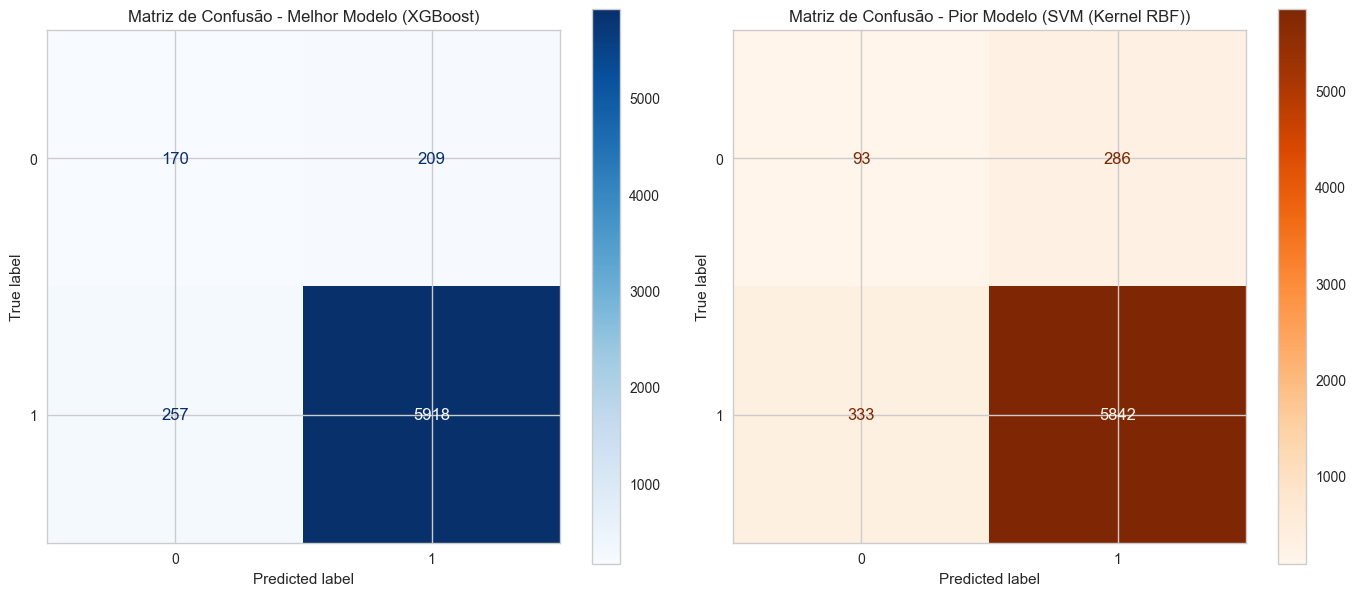

In [98]:
# Define explicitamente os nomes dos modelos
best_model_name = "XGBoost"
worst_model_name = "SVM (Kernel RBF)"

# Carrega os pipelines otimizados
best_model = joblib.load(f'modelos/{best_model_name}_otimizado.pkl')
worst_model = joblib.load(f'modelos/{worst_model_name}_otimizado.pkl')

# Faz as previsões
y_pred_best = best_model.predict(X_test_clean)
y_pred_worst = worst_model.predict(X_test_clean)

# Plota as matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, ax=axes[0], cmap='Blues')
axes[0].set_title(f'Matriz de Confusão - Melhor Modelo ({best_model_name})')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_worst, ax=axes[1], cmap='Oranges')
axes[1].set_title(f'Matriz de Confusão - Pior Modelo ({worst_model_name})')

plt.tight_layout()
plt.show()


--- Matriz de Confusão ---


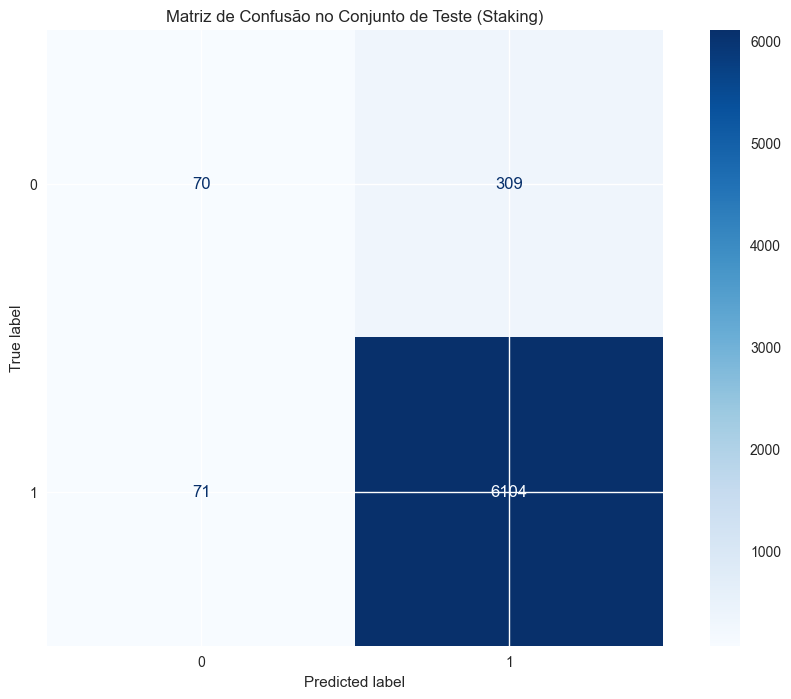

In [17]:
# Faz as previsões
y_pred_test = final_model.predict(X_test_clean)


# Gera e exibe a Matriz de Confusão
print("--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão no Conjunto de Teste (Staking)')
plt.show()


Avaliando o comitê no conjunto de teste...
--- Matriz de Confusão (Comitê MLPs) ---


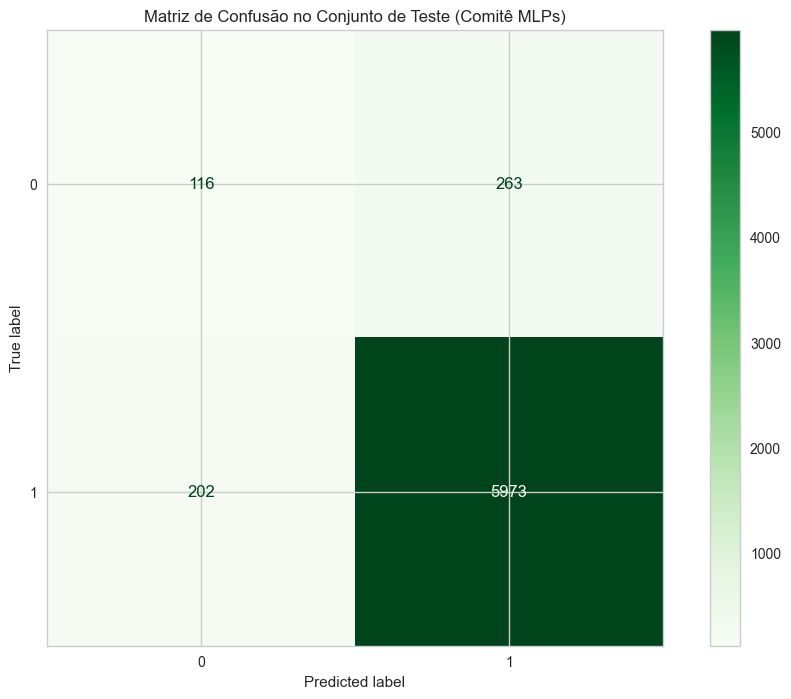

In [101]:
# --- Avaliação do Modelo ---

# Faz as previsões no conjunto de teste
print("\nAvaliando o comitê no conjunto de teste...")
y_pred_mlp_test = final_mlp_model.predict(X_test_clean)


# Gera e exibe a Matriz de Confusão
print("--- Matriz de Confusão (Comitê MLPs) ---")
cm_mlp = confusion_matrix(y_test, y_pred_mlp_test)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=final_mlp_model.classes_)
disp_mlp.plot(cmap='Greens', values_format='d')
plt.title('Matriz de Confusão no Conjunto de Teste (Comitê MLPs)')
plt.show()

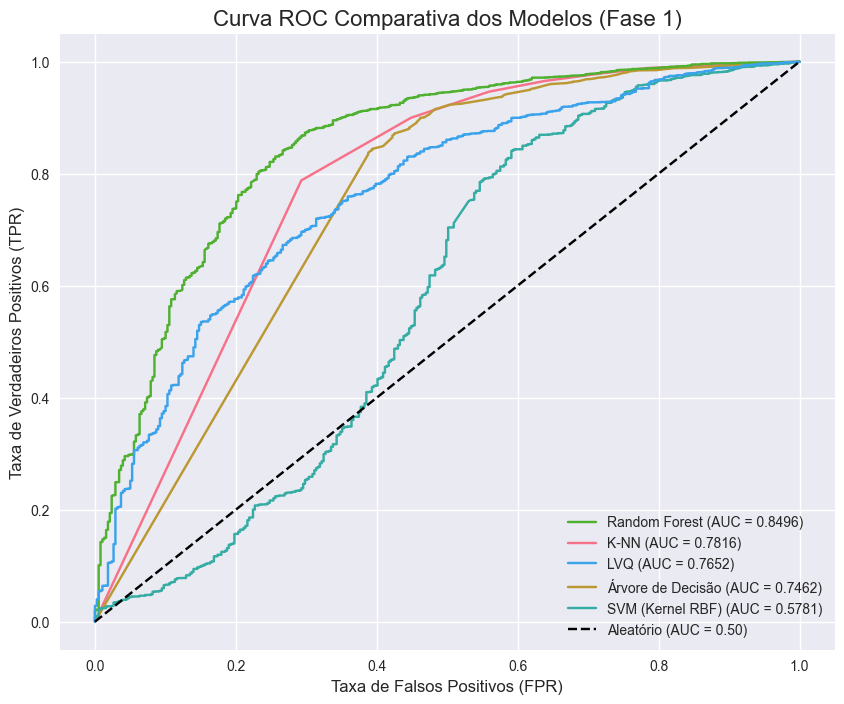

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(10, 8))
handles_labels = []

# Dicionário de modelos para Fase 1 (nomes e caminhos dos arquivos otimizados)
modelos_fase1 = {
    "K-NN": "modelos/K-NN_otimizado.pkl",
    "Árvore de Decisão": "modelos/Árvore de Decisão_otimizado.pkl",
    "Random Forest": "modelos/Random Forest_otimizado.pkl",
    "SVM (Kernel RBF)": "modelos/SVM (Kernel RBF)_otimizado.pkl",
    "LVQ": "modelos/GMLVQ_otimizado.pkl"
}

for nome, caminho in modelos_fase1.items():
    try:
        modelo = joblib.load(caminho)
        y_proba = modelo.predict_proba(X_test_clean)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        line, = plt.plot(fpr, tpr, label=f'{nome} (AUC = {auc:.4f})')
        handles_labels.append((line, auc, nome))
    except Exception as e:
        print(f"Erro ao processar {nome}: {e}")

ref_line, = plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.50)')
handles_labels.append((ref_line, 0.5, 'Aleatório (AUC = 0.50)'))

handles_labels_sorted = sorted(handles_labels, key=lambda x: x[1], reverse=True)
handles_sorted = [h[0] for h in handles_labels_sorted]
labels_sorted = [h[0].get_label() for h in handles_labels_sorted]

plt.title('Curva ROC Comparativa dos Modelos (Fase 1)', fontsize=16)
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
plt.legend(handles=handles_sorted, labels=labels_sorted)
plt.grid(True)
plt.show()


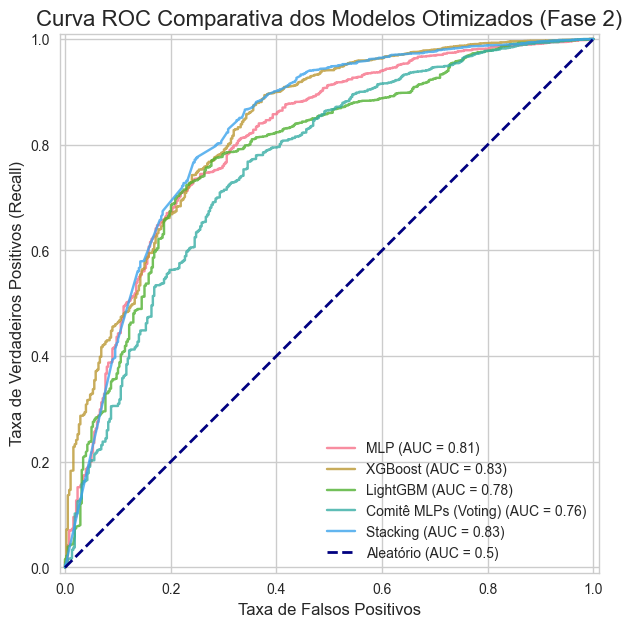

In [102]:
# Cria a figura e o eixo para o plot
fig, ax = plt.subplots(figsize=(10, 7))

# Itera sobre os melhores modelos carregados para plotar cada curva
for name, model_pipeline in best_models_fase2.items():
    try:
        RocCurveDisplay.from_estimator(
            model_pipeline, 
            X_test_clean, 
            y_test, 
            name=name, 
            ax=ax, 
            alpha=0.8
        )
    except Exception as e:
        print(f"Não foi possível plotar a curva ROC para o modelo '{name}': {e}")


# Adiciona a linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.5)')

# Customiza o gráfico
plt.title('Curva ROC Comparativa dos Modelos Otimizados (Fase 2)', fontsize=16)
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

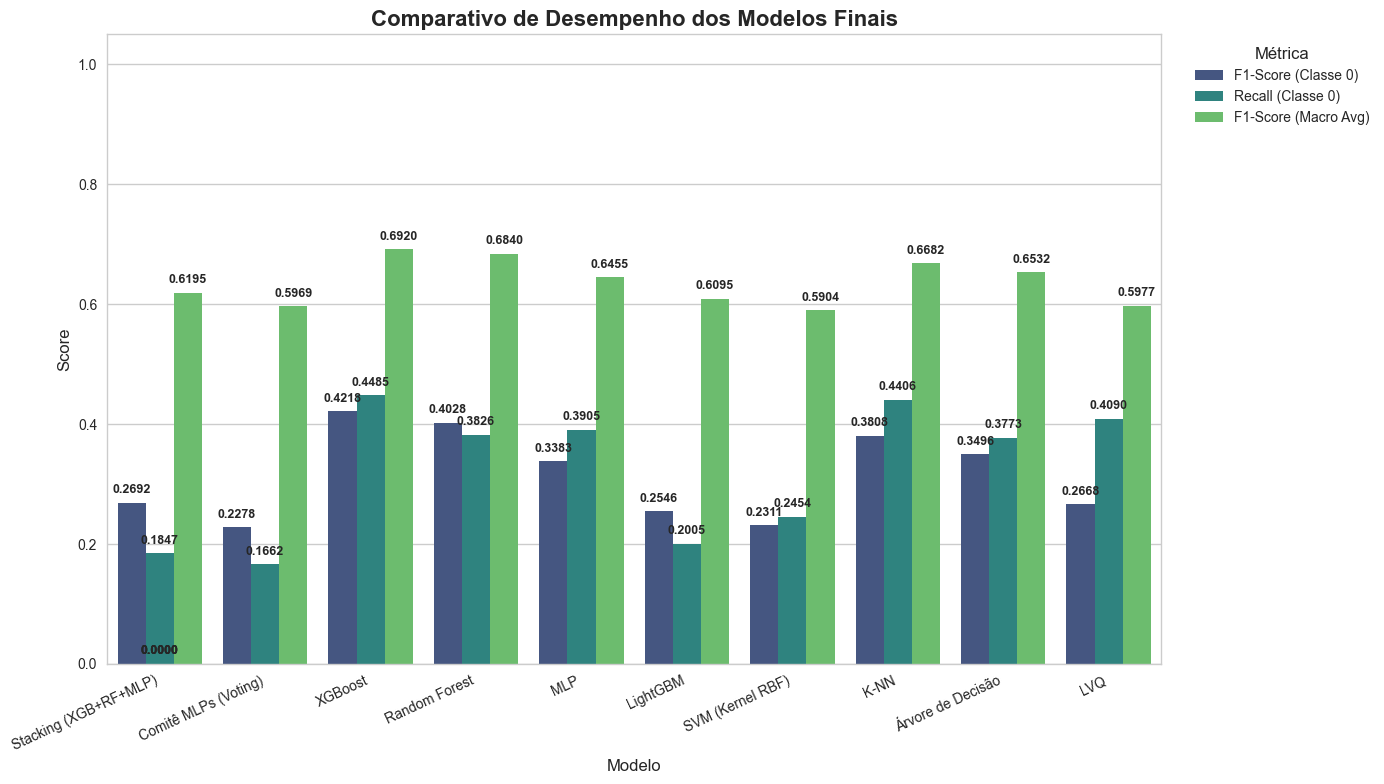

In [18]:


# --- 1. Defina os nomes e caminhos dos seus modelos finais ---
# Adapte os nomes e caminhos conforme necessário
modelos_para_comparar = {
    "Stacking (XGB+RF+MLP)": "modelos/stacking_model_otimizado.pkl",
    "Comitê MLPs (Voting)": "modelos/comite_mlp_final.pkl",
    "XGBoost": "modelos/XGBoost_otimizado.pkl",
    "Random Forest": "modelos/Random Forest_otimizado.pkl",
    "MLP": "modelos/MLP_otimizado.pkl",
    "LightGBM": "modelos/LightGBM_otimizado.pkl",
    "SVM (Kernel RBF)": "modelos/SVM (Kernel RBF)_otimizado.pkl",
    "K-NN": "modelos/K-NN_otimizado.pkl",
    "Árvore de Decisão": "modelos/Árvore de Decisão_otimizado.pkl",
    "LVQ": "modelos/GMLVQ_otimizado.pkl"
}

# --- 2. Calcule as métricas para cada modelo ---
resultados = []
for nome, caminho in modelos_para_comparar.items():
    try:
        # Carrega o modelo
        modelo = joblib.load(caminho)

        # Faz predições no conjunto de teste
        y_pred = modelo.predict(X_test_clean)

        # Gera o relatório de classificação e extrai as métricas
        report = classification_report(y_test, y_pred, output_dict=True)

        f1_classe_0 = report['0']['f1-score']
        recall_classe_0 = report['0']['recall']
        f1_macro = report['macro avg']['f1-score']

        resultados.append({
            "Modelo": nome,
            "F1-Score (Classe 0)": f1_classe_0,
            "Recall (Classe 0)": recall_classe_0,
            "F1-Score (Macro Avg)": f1_macro
        })

    except FileNotFoundError:
        print(f"--> Aviso: Arquivo não encontrado em '{caminho}'. Pulando este modelo.")
    except Exception as e:
        print(f"--> Erro ao processar o modelo {nome}: {e}")


# --- 3. Crie e exiba o gráfico de barras ---
if resultados:
    # Converte os resultados para um DataFrame do Pandas
    df_resultados = pd.DataFrame(resultados)
    df_melted = df_resultados.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

    # Plota o gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(data=df_melted, x="Modelo", y="Valor", hue="Métrica", palette="viridis")

    # Adiciona os valores nas barras para melhor visualização
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=9,
                    fontweight='bold')

    plt.title('Comparativo de Desempenho dos Modelos Finais', fontsize=16, fontweight='bold')
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Modelo', fontsize=12)
    plt.xticks(rotation=25, ha="right")
    plt.ylim(0, 1.05)
    plt.legend(title='Métrica', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print("\\nNenhum resultado para plotar. Verifique os caminhos dos arquivos dos modelos.")

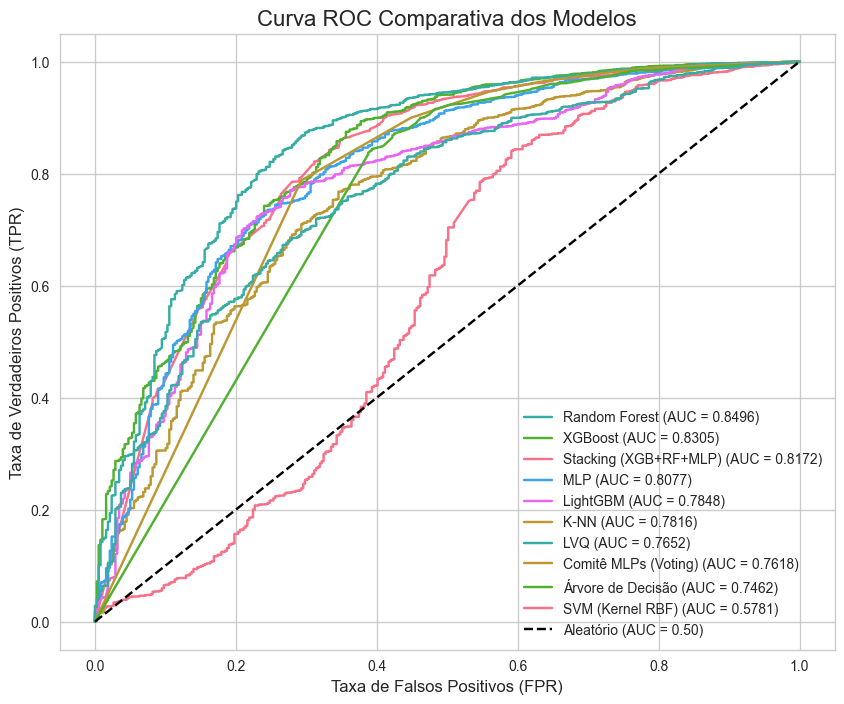

In [ ]:

plt.figure(figsize=(10, 8))
handles_labels = []

# Plota a curva para cada modelo e armazena handles/labels para ordenação posterior
for nome, caminho in modelos_para_comparar.items():
    modelo = joblib.load(caminho)
    y_proba = modelo.predict_proba(X_test_clean)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    line, = plt.plot(fpr, tpr, label=f'{nome} (AUC = {auc:.4f})')
    handles_labels.append((line, auc, nome))

# Linha de referência (modelo aleatório)
ref_line, = plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.50)')
handles_labels.append((ref_line, 0.5, 'Aleatório (AUC = 0.50)'))

# Ordena as legendas por AUC decrescente
handles_labels_sorted = sorted(handles_labels, key=lambda x: x[1], reverse=True)
handles_sorted = [h[0] for h in handles_labels_sorted]
labels_sorted = [h[0].get_label() for h in handles_labels_sorted]

plt.title('Curva ROC Comparativa dos Modelos', fontsize=16)
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
plt.legend(handles=handles_sorted, labels=labels_sorted)
plt.grid(True)
plt.show()


               ANÁLISE DE ACERTOS E ERROS - CLASSE 0 (ACESSO NEGADO)
                       Acertos (Classe 0 | TN)  Erros (Previu 1 | FP)  \
Modelo                                                                  
Stacking (XGB+RF+MLP)                       70                    309   
Comitê MLPs (Voting)                        63                    316   
XGBoost                                    170                    209   
Random Forest                              145                    234   
MLP                                        148                    231   
LightGBM                                    76                    303   
SVM (Kernel RBF)                            93                    286   
K-NN                                       167                    212   
Árvore de Decisão                          143                    236   
LVQ                                        155                    224   

                       Erros (Previu 0 | FN)  Total d

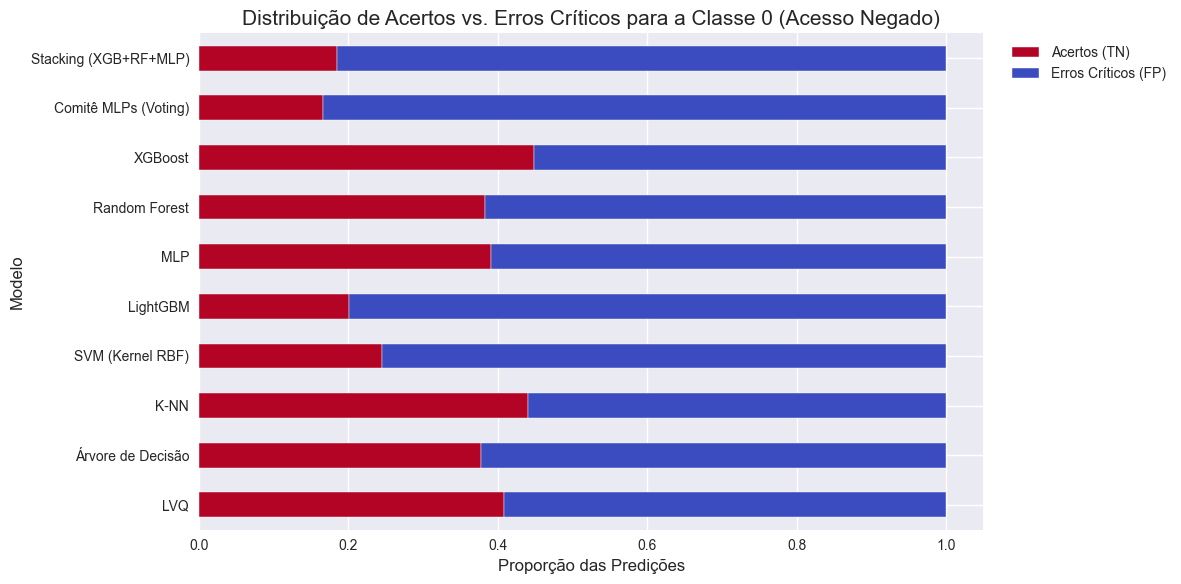

In [22]:

# --- 1. Define os modelos para análise ---
modelos_para_analise = {
    "Stacking (XGB+RF+MLP)": "modelos/stacking_model_otimizado.pkl",
    "Comitê MLPs (Voting)": "modelos/comite_mlp_final.pkl",
    "XGBoost": "modelos/XGBoost_otimizado.pkl",
    "Random Forest": "modelos/Random Forest_otimizado.pkl",
    "MLP": "modelos/MLP_otimizado.pkl",
    "LightGBM": "modelos/LightGBM_otimizado.pkl",
    "SVM (Kernel RBF)": "modelos/SVM (Kernel RBF)_otimizado.pkl",
    "K-NN": "modelos/K-NN_otimizado.pkl",
    "Árvore de Decisão": "modelos/Árvore de Decisão_otimizado.pkl",
    "LVQ": "modelos/GMLVQ_otimizado.pkl"
}

error_analysis_results = []
for nome, caminho in modelos_para_analise.items():
    try:
        modelo = joblib.load(caminho)
        y_pred = modelo.predict(X_test_clean)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        error_analysis_results.append({
            "Modelo": nome,
            "Acertos (Classe 0 | TN)": tn,
            "Erros (Previu 1 | FP)": fp,
            "Erros (Previu 0 | FN)": fn,
            "Total de Casos Reais (Classe 0)": tn + fp
        })

    except FileNotFoundError:
        print(f" Arquivo não encontrado em '{caminho}'.")
    except Exception as e:
        print(f" Erro ao processar o modelo {nome}: {e}")


if error_analysis_results:
    df_erros = pd.DataFrame(error_analysis_results)
    df_erros = df_erros.set_index('Modelo')

    # Identifica o melhor modelo (maior número de acertos na classe 0)
    melhor_modelo_nome = df_erros["Acertos (Classe 0 | TN)"].idxmax()
    melhores_dados = df_erros.loc[melhor_modelo_nome]

    print("\n" + "="*60)
    print("               ANÁLISE DE ACERTOS E ERROS - CLASSE 0 (ACESSO NEGADO)")
    print("="*60)
    print(df_erros)
    print("="*60)

    print(f"\n O modelo que MAIS ACERTA a Classe 0 é o: '{melhor_modelo_nome}'")
    print(f"\nDetalhes do modelo '{melhor_modelo_nome}':")
    print(f"  -  Acertou: {melhores_dados['Acertos (Classe 0 | TN)']} previsões de 'Acesso Negado'.")
    print(f"  - Errou (prevendo 'Permitido'): {melhores_dados['Erros (Previu 1 | FP)']} vezes. (ERRO CRÍTICO)")
    print(f"  - De um total de {melhores_dados['Total de Casos Reais (Classe 0)']} casos reais de 'Acesso Negado' no conjunto de teste.")


    # ---  visualização focada nos erros ---
    df_plot = df_erros[["Acertos (Classe 0 | TN)", "Erros (Previu 1 | FP)"]].copy()
    df_plot_percent = df_plot.div(df_plot.sum(axis=1), axis=0) # Normaliza para percentual

    ax = df_plot_percent.plot(
        kind='barh',
        stacked=True,
        figsize=(12, 6),
        colormap='coolwarm_r',
        edgecolor='white'
    )

    plt.title('Distribuição de Acertos vs. Erros Críticos para a Classe 0 (Acesso Negado)', fontsize=15)
    plt.xlabel('Proporção das Predições', fontsize=12)
    plt.ylabel('Modelo', fontsize=12)
    plt.legend(["Acertos (TN)", "Erros Críticos (FP)"], bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.gca().invert_yaxis() # Coloca o melhor modelo no topo
    plt.tight_layout()
    plt.show()

else:
    print("\\nNenhum resultado para analisar.")